# This notebook is to generate the plot in Figure 1

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import os
from numpy import ma
import seaborn as sns
%matplotlib inline
from sklearn.preprocessing import StandardScaler
from scipy import stats
from natsort import natsorted
from glob import glob
import glob
from statistics import mean

In [2]:
# set working directory

os.chdir('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls')

In [ ]:
# load this data file from the GitHub page

dfSarcoma = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/vanTine_001_FinalDataWithControls/MQ/vanTine_001_90_samples/Protein/Model/ProteinQuantitationWithSampleMetadata.xlsx', sheet_name='Sheet1')

In [4]:
df = dfSarcoma

df = df.loc[:,~df.columns.str.contains('CON_')] # remove contaminants
df = df.query("dataType == 'Intensity_Raw'")

totalCols = df.columns
numCols = df._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

df = pd.melt(df,
    id_vars = catCols,
    value_vars = numCols,
    var_name = 'protAcc',
    value_name="area",
    ignore_index=False,
    )

#remove rows without areas & duplicates
df.dropna(subset=['area'], inplace=True)
df.drop_duplicates(inplace = True)

# add a column 'sarcoma' for clarity
dataset = 'sarcoma'
df.insert(loc=1, column='dataset', value=dataset)

dfSarcoma = df

In [ ]:
# This file is on the GitHub page

dfUniprot = pd.read_excel('/Users/jasonheld/Manuscripts/2022_Sarcoma-Exosomes/Figure2_Data_CancerVsNormal/uniprotAnnotationsForFigure2.xlsx')
dfUniprot = dfUniprot.rename(columns={'Entry' : 'protAcc'})
dfUniprot = dfUniprot.rename(columns={'Gene Names (primary)' : 'geneNamePrimary'})
dfUniprot = dfUniprot.drop(columns=['Length','Entry Name','Organism','Gene Names'])
dfUniprot['protAcc'] = dfUniprot['protAcc'].astype(str)
dfUniprot.drop_duplicates(subset=['protAcc'], inplace = True)

In [6]:
# annotate uniprot info by merging with dfUniprot

dfSarcoma = dfSarcoma.merge(dfUniprot, on='protAcc', how='left')

totalCols = dfSarcoma.columns
numCols = dfSarcoma._get_numeric_data().columns
catCols = list(set(totalCols)-set(numCols))

dfSarcoma['area'] = dfSarcoma['area'].astype(float)

In [7]:
# remove CRAPome

df = dfSarcoma

crapome =['KRT1', 'KRT2', 'KRT3', 'KRT4', 'KRT5', 'KRT6', 'KRT7', 'KRT8', 'KRT9', 'KRT10', 'KRT11', 'KRT12', 'KRT13', 'KRT14', 'KRT15', 'KRT16', 'KRT17', 'KRT18', 'KRT19', 'KRT20', 'KRT21', 'KRT22', 'KRT23', 'KRT24']

df = df.loc[~df['geneNamePrimary'].str.contains('|'.join(crapome))] 

dfSarcoma = df

In [8]:
# proteins detected per samples (e.g. number of non zeros)

dfSarcomaPivot = pd.pivot_table(
    data=dfSarcoma,
    index = ['sample','cancer','timing'],
    columns = 'geneNamePrimary',
    values = 'area'
)

In [ ]:
exoGeneList = ['CD9', 'CD63', 'CD81', # classical exosomes
                'HSPA13', 'MTHFD1', 'IHD1',# exomere
                'ANXA1', 'ARF6', 'TSG101', # microvesicle
                'PDCD6IP', # ALIX
                'SDCBP', # syntenin-1, universal biomarker
                'FLOT1', 'CD40', 'ANXA6', # misc
                'HSPA8', 'ANXA2', 'GAPDH', 'ENO1', 'HSP90AA1', 'PKM' # http://exocarta.org
              ]

In [10]:
# calc median intensity of each protein

dfProteinIntensity = pd.DataFrame()

#dfProteinIntensity.index = dfTemp.T.index
dfProteinIntensity['medianIntensity'] = dfSarcomaPivot.median(axis = 0)
dfProteinIntensity['meanIntensity'] = dfSarcomaPivot.mean(axis = 0)

# add rank columns
dfProteinIntensity['medianIntensityRank'] = dfProteinIntensity['medianIntensity'].rank(method = 'first', ascending = False)
dfProteinIntensity['meanIntensityRank'] = dfProteinIntensity['meanIntensity'].rank(method = 'first', ascending = False)
dfProteinIntensity

,medianIntensity,meanIntensity,medianIntensityRank,meanIntensityRank
geneNamePrimary,,,,
A1BG,5773000.0,6.576969e+06,126.0,138.0
AADAT,0.0,0.000000e+00,1196.0,3419.0
AAGAB,0.0,2.980589e+04,1197.0,2036.0
AARS1,18792.5,2.317269e+05,1147.0,1026.0
ABAT,0.0,7.489000e+02,1198.0,3247.0
...,...,...,...,...
ZNF385B,0.0,0.000000e+00,3456.0,3458.0
ZSWIM9,0.0,1.611611e+04,3457.0,2329.0
ZW10,0.0,1.636654e+04,3458.0,2320.0


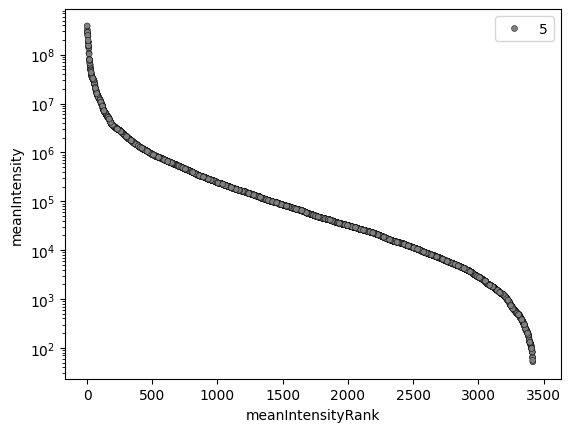

In [11]:
# plot
sns.scatterplot(data = dfProteinIntensity,
        x= 'meanIntensityRank',
        y = 'meanIntensity',
        size=5,
        facecolor = 'grey',
        edgecolor = 'black',)
plt.yscale('log')

/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_26741/3079745642.py:19: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  (dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].meanIntensityRank[i], # x
/var/folders/39/4j31xtfn0k1gbr7xx3tcxqgw0000gr/T/ipykernel_26741/3079745642.py:20: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].meanIntensity[i], # y


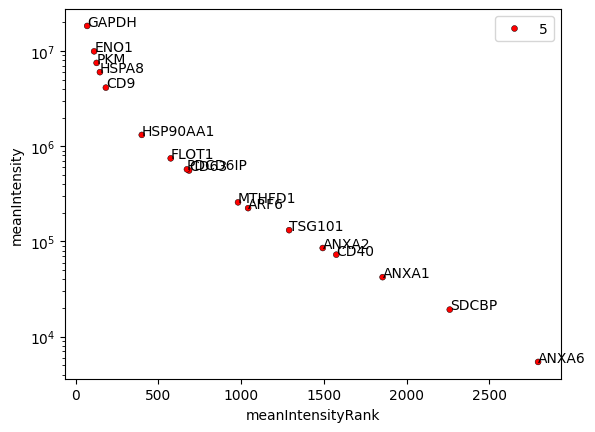

In [12]:
# exomarkers

mask = dfProteinIntensity.index.isin(exoGeneList)

sns.scatterplot(data = dfProteinIntensity.loc[mask],
        x = 'meanIntensityRank',
        y = 'meanIntensity',
        size=5,
        facecolor = 'red',
        edgecolor = 'black',)
plt.yscale('log')

# Loop for annotation of all points

annotations = dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].index # gene names

for i in range(len(dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].meanIntensityRank)):
    plt.annotate(annotations[i],
        (dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].meanIntensityRank[i], # x
             dfProteinIntensity[dfProteinIntensity.index.isin(exoGeneList)].meanIntensity[i], # y
        )
    ) 